In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from utils import select_available, train_func_approx
from model import ClassicNet, FourierNet

device = torch.device('cpu')

In [2]:
def func(x):
    return x**2
    # return x**2 - torch.exp(-2*x**2)
    # return torch.sin(x) + torch.cos(3*x) + torch.sin(5*x)

def d_func_dx(x):
    return 2*x
    # return 2*x + 4*x*torch.exp(-2*x**2)
    # return torch.cos(x) - 3*torch.sin(3*x) + 5*torch.cos(5*x)

In [3]:
domain = torch.linspace(-np.pi, np.pi, 200).unsqueeze(1)
solution = func(domain)

features_in = 1
features_out = 1
hidden = [100, 100, 100]

model = FourierNet(features_in, hidden, features_out)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 1000

images = train_func_approx(model, domain, solution, num_epochs, optimizer, loss_fn, device, atol=1e-5, plot_interval=10, gif_save_path='gif_test2')


Training Progress: 100%|███████████████| 1000/1000 [00:07<00:00, 141.87it/s, Train Loss: 0.00008017]


GIF saved at gif_test2/cas_100_100_100.gif


In [4]:
model.eval()
parameter_count = sum(p.numel() for p in model.parameters())

x_point = torch.tensor([1.0], requires_grad=True).to(device)
output = model(x_point).to(device)
output.backward()

exact_value = func(x_point).item()
exact_derivative = d_func_dx(x_point).item()

value_error = abs(output.item() - exact_value)
derivative_error = abs(x_point.grad.item() - exact_derivative)

results = (
    f"Model parameter count: {parameter_count}\n"
    f"--- At x={x_point.item():.4f} ---\n"
    f"Prediction: {output.item():.4f}, Exact: {exact_value:.4f}, Abs Error: {value_error:.4f}\n"
    f"Derivative: {x_point.grad.item():.4f}, Exact: {exact_derivative:.4f}, Abs Error: {derivative_error:.4f}"
)

print(results)

Model parameter count: 40301
--- At x=1.0000 ---
Prediction: 1.0011, Exact: 1.0000, Abs Error: 0.0011
Derivative: 2.0254, Exact: 2.0000, Abs Error: 0.0254


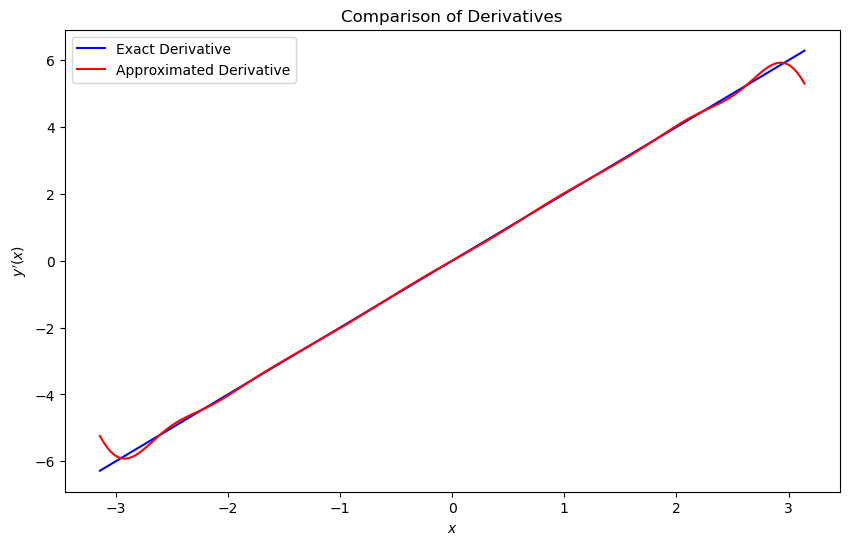

In [5]:
model.eval()

domain.requires_grad_(True)
output = model(domain)

gradients_model = torch.autograd.grad(outputs=output, inputs=domain,
                                      grad_outputs=torch.ones_like(output),
                                      create_graph=True)[0]

exact_derivatives = d_func_dx(domain).detach()

domain_np = domain.detach().cpu().numpy()
gradients_model_np = gradients_model.detach().cpu().numpy()
exact_derivatives_np = exact_derivatives.cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(domain_np, exact_derivatives_np, label="Exact Derivative", color="blue")
plt.plot(domain_np, gradients_model_np, label="Approximated Derivative", color="red")
plt.xlabel("$x$")
plt.ylabel("$y'(x)$")
plt.legend()
plt.title('Comparison of Derivatives')
plt.show()
